# Sampler Chains

## Packages

We begin by loading in necessary software packages.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging

import pystan
import re
import time

In [2]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = '../results/zinser_results_chains.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

save_only_converged = False

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

# Number of days of data to fit
limit_days = 2

# Whether or not data limit is inclusive (include boundary point)
inclusive = False

# Whether to append dataset to itself to create a 96-hour dataset
# This option is used for validation experiments in rolling_window.ipynb
extend = False

# Whether to append results to an existing file or overwrite
append = False

## Load, Plot Data

In [3]:
# load processed data
datafile = '../data/size_distribution/zinser_processed.nc'

dataname = 'zinser'

desc = 'Culture dataset'

# Indices of data to hold out for hold-out validation
# Uncomment desired line and set use_testdata to true
itestfile = None
# itestfile = '../data/hold_out/keep_twothirds.csv'
# itestfile = '../data/hold_out/keep_half.csv'
# itestfile = '../data/hold_out/keep_onethird.csv'

size_units = 'fg C cell$^{-1}$'


def get_data(datafile, size_units, itestfile, dataname, desc, extend=False):
    
    data_gridded = {}
    with nc4.Dataset(datafile) as nc:
        for var in nc.variables:
            data_gridded[var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded:
        data_gridded['counts'] = (data_gridded['count'][None,:]
                                  * data_gridded['w_obs']).astype(int)
    elif 'abundance' in data_gridded:
        logging.warning('Using "abundance" data to generate count data for the model.')
        data_gridded['counts'] = (data_gridded['count'][None,:]
                                  * data_gridded['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafile))
    
    # Appends the time series to itself to create a pseudo four-day dataset
    if extend:
        data_gridded['time'] = np.concatenate((data_gridded['time'],
                                               (data_gridded['time']
                                               + data_gridded['time'][-1]
                                               + data_gridded['time'][1])[:-1]))
        
        for item in ('w_obs', 'PAR', 'abundance', 'count', 'counts'):
            if len(data_gridded[item].shape) == 2:
                data_gridded[item] = np.concatenate((data_gridded[item],
                                                     data_gridded[item][:, 1:]), axis=1)
            else:
                data_gridded[item] = np.concatenate((data_gridded[item],
                                                     data_gridded[item][1:]))

    # add description
    desc += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded)
    
    return data_gridded, desc

data_gridded, desc = get_data(datafile, size_units, itestfile, dataname, desc, extend=extend)

/Users/kristof/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


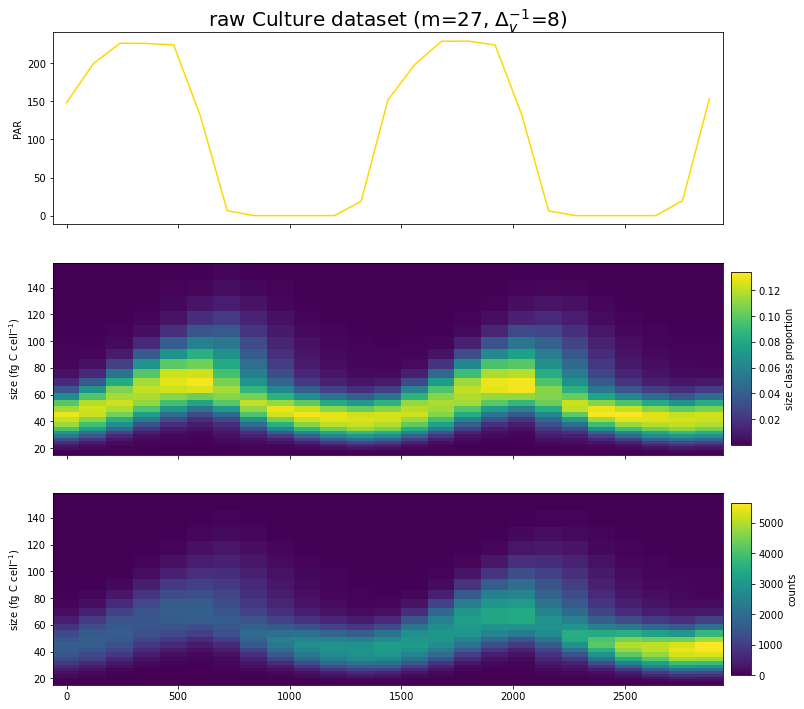

In [4]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5,
                            bbox_to_anchor=(0.05,0.0,1,1),
                            bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical',
                              **cbarargs)

if show_data:
    nrows = 3

    v_min = data_gridded['v_min']
    delta_v = 1.0/data_gridded['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.set_title('raw '+desc, size=20)
    ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
    ax.set(ylabel='PAR')

    ax = axs[1]
    pc = ax.pcolormesh(data_gridded['time'], v, data_gridded['w_obs'],
                       shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[2]
    pc = ax.pcolormesh(data_gridded['time'], v, data_gridded['counts'],
                       shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
axs[-1].set_xlabel=('time (minutes)')
None

## Process and Re-plot Data

In [5]:
# prepare data for Stan model
def data_prep(data_gridded, dt=20, limit_days=2, start=0, use_testdata=False,
              itestfile=None, prior_only=False, inclusive=False):
    
    data = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[v] = data_gridded[v]

    data['obs'] = data_gridded['w_obs']
    data['t_obs'] = data_gridded['time']
    par = data_gridded['PAR']

    if limit_days > 0:
        limit_minutes = limit_days*1440

        if inclusive:
            ind_obs = (start*60 <= data['t_obs']) & (data['t_obs'] <= limit_minutes+start*60)
        else:
            ind_obs = (start*60 <= data['t_obs']) & (data['t_obs'] < limit_minutes+start*60)

        if not np.all(ind_obs):
            total = data['obs'].shape[1]
            remove = total - data['obs'][:, ind_obs].shape[1]
            print('start is set to {}, limit_days is set to {}, removing {}/{} observation times'.format(start,
                                                                                                         limit_days,
                                                                                                         remove,
                                                                                                         total))

        data['t_obs'] = data['t_obs'][ind_obs]
        data['obs'] = data['obs'][:,ind_obs]

        data['nt'] = int(limit_minutes//data['dt']+1)

    data['nt_obs'] = data['t_obs'].size

    if use_testdata:
        # load cross-validation testing indices and add them to data
        data['i_test'] = np.loadtxt(itestfile).astype(int)
        # remove last index, so that dimensions agree
        data['i_test'] = data['i_test'][:-1]
    else:
        # set all indices to zero
        data['i_test'] = np.zeros(data['nt_obs'], dtype=int)

    # switch on or off data fitting
    data['prior_only'] = int(prior_only)

    # add light data
    t = np.arange(data['nt'])*data['dt'] + start*60
    data['E'] = np.interp(t, xp=data_gridded['time'][ind_obs], fp=par[ind_obs])

    # real count data
    data['obs_count'] = data_gridded['counts'][:, ind_obs]
    
    data['start'] = start

    # consistency check
    if len(data['i_test']) != data['nt_obs']:
        raise ValueError('Invalid number of testing indices (expected {}, got {}).'.format(data['nt_obs'],
                                                                                       len(data['i_test'])))
    return data


data = data_prep(data_gridded, dt=20, limit_days=limit_days, start=0,
                 use_testdata=use_testdata, itestfile=itestfile,
                 prior_only=prior_only, inclusive=False)

start is set to 0, limit_days is set to 2, removing 1/25 observation times


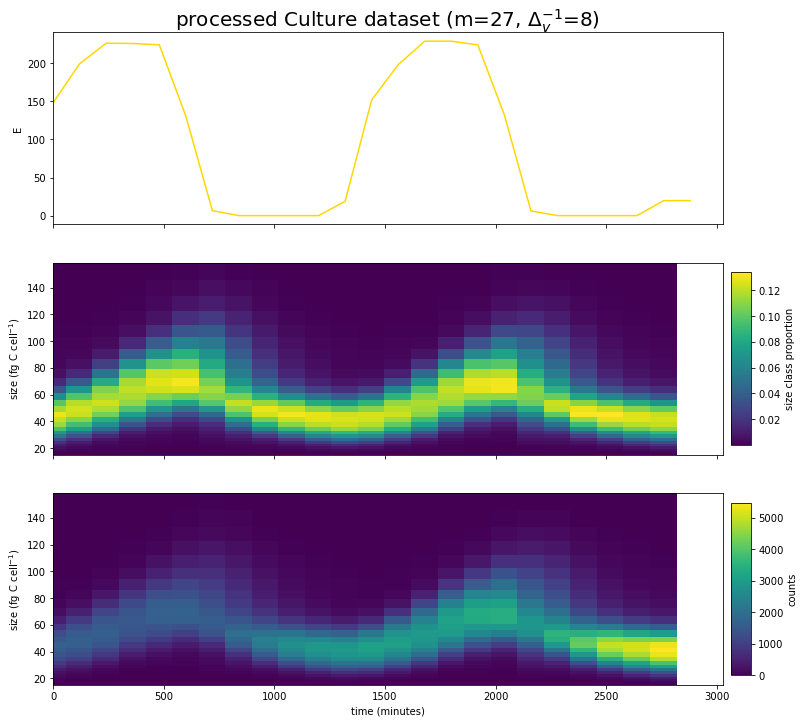

In [6]:
if show_data:
    nrows = 3

    v_min = data['v_min']
    delta_v = 1.0/data['delta_v_inv']
    v = v_min * 2**(np.arange(data['m'])*delta_v) 
    t = np.arange(data['nt'])*data['dt']


    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.set_title('processed '+desc, size=20)
    ax.plot(t, data['E'], color='gold')
    ax.set(ylabel='E')

    ax = axs[1]
    pc = ax.pcolormesh(data['t_obs'], v, data['obs'], shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap,
                 label='size class proportion')
    ax.set_xlim(left=0.0)

    ax = axs[2]
    pc = ax.pcolormesh(data['t_obs'], v, data['obs_count'], shading='auto')
    ax.set(ylabel='size ({})'.format(size_units))
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')
None

## Choose models to fit

In [7]:
# Code files
stan_files = {
#     'm_bmx': '../stan_code/m_bmx.stan',
    'm_bmb': '../stan_code/m_bmb.stan',
#     'm_pmb': '../stan_code/m_pmb.stan',
#     'm_fmb': '../stan_code/m_fmb.stan',
#     'm_fmf': '../stan_code/m_fmf.stan',
#     'm_btb': '../stan_code/m_btb.stan',
#     'm_ptb': '../stan_code/m_ptb.stan',
#     'm_ftb': '../stan_code/m_ftb.stan',
    'm_ftf': '../stan_code/m_ftf.stan',
}

## Fit Models and Save Results

In [8]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'models' not in globals():
    models = {}
if 'num_tries' not in globals():
    num_tries = 3
    
try_again = True
refit_all = False

refit_required = {}
stan_base_code = {}
for key, stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in stan_files.keys():
    code_split = stan_base_code[model].split('\n')
    stan_code[model] = '\n'.join(code_split)

In [9]:
for model in stan_files.keys():
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model],
                                         model_name=model,
                                         obfuscate_model_name=False)


# run a bunch of experiments -- this may take a while
for model in models:
    for itry in range(num_tries):
        t0 = time.time()
        mcmcs = models[model].sampling(data=data, iter=2000, chains=num_chains,
                                       chain_id=np.arange(num_chains))
        sampling_time = time.time() - t0  # in seconds
        print('Model {} for {}-hour window starting at {} hours fit in {} minutes.'.format(model,
                                                                                           limit_days*24+2*int(inclusive),
                                                                                           data['start'],
                                                                                           np.round(sampling_time/60, 2)))
        # get max Rhat
        rhat_max = get_max_rhat(mcmcs)
        print('{}: in try {}/{} found Rhat={:.3f}'.format(model, itry+1, num_tries, rhat_max), end='')
        if rhat_max < 1.1 or itry == num_tries - 1:
            print()
            break
        print(', trying again')

    print('{}'.format(model)) 
    print('\n'.join(x for x in mcmcs.__str__().split('\n') if '[' not in x))
    print()
    
    
    
    if 'varnames_save' not in globals():
        varnames_save = None

    if savename_output is not None:
        if model == tuple(models.keys())[0] and append == False:
            mode = 'w'
        else:
            mode = 'a'
        with nc4.Dataset(savename_output, mode) as nc:
            ncm = nc.createGroup(model)

            # write model description
            ncm.setncattr('code', stan_files[model])

            if save_stan_output:
                if save_only_converged and get_max_rhat(mcmcs) > 1.1:
                    logging.warning('Model "{}" did not converge -- skipping.'.format(model))
                    continue
                dimensions = {
                    'sample': mcmcs.extract(pars='sigma', permuted=False)['sigma'].shape[0],
                    'chains': mcmcs.extract(pars='sigma', permuted=False)['sigma'].shape[1]
                }

                for d in dimensions:
                    if d not in ncm.dimensions:
                        ncm.createDimension(d, dimensions[d])
                
                pars = mcmcs.extract(pars=mcmcs.flatnames, permuted=False)
                for item in pars.keys():
                    if item not in ncm.variables:
                        ncm.createVariable(item, float, ('sample', 'chains'))
                    ncm.variables[item][:] = pars[item]

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_bmb NOW.


m_bmb: compiling
m_ftf: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_ftf NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_bmb for 48-hour window starting at 0 hours fit in 20.81 minutes.
m_bmb: in try 1/3 found Rhat=1.003
m_bmb
Inference for Stan model: m_bmb.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                         mean se_mean      sd     2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_max               49.48    0.17    9.56    32.49   42.37   49.14   56.02   68.51   3348    1.0
gamma_max                6.17  5.9e-3     0.3     5.39    6.01    6.25     6.4    6.51   2692    1.0
rho_max                  0.84  3.7e-4    0.03     0.79    0.82    0.84    0.86     0.9   5949    1.0
E_star                 263.96    0.43   22.44   210.54  251.63  267.39  279.71  298.66   2749    1.0
sigma                   348.6    0.24   19.29   312.29  335.34  348.29  361.24  387.54   6649    1.0
divrate                  0.62  2.8e-4    0.02     0.58    0.61    0.62    0.64    0.67   6640    1.0
lp__                   -1.4e

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Model m_ftf for 48-hour window starting at 0 hours fit in 136.77 minutes.
m_ftf: in try 1/3 found Rhat=1.020
m_ftf
Inference for Stan model: m_ftf.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean      sd    2.5%    25%     50%     75%  97.5%  n_eff   Rhat
delta_max              14.99    0.03    1.66   12.31  13.81   14.82   15.93  18.96   2355    1.0
gamma_mu                4.51  5.5e-3    0.37     3.8   4.26    4.51    4.75   5.25   4497    1.0
gamma_sigma             1.76  4.0e-3    0.28    1.32   1.56    1.73    1.92   2.41   4806    1.0
rho_mu                  0.45  1.2e-3    0.07    0.32    0.4    0.45    0.49   0.58   2973    1.0
rho_sigma                0.3  7.2e-4    0.05    0.22   0.27    0.29    0.33   0.42   4811    1.0
E_star                294.27    0.52   13.45  265.98 286.05  295.02  303.45  318.2    673   1.01
sigma                 3912.2    4.15  274.53  3401.4 37